# Personalized Movie Recommendation System with Time-dependent Dynamic Filtering

## Description
You are required to build a personalized movie recommendation system that suggests movies to users based on their past ratings and the ratings of other users with similar tastes. The system should also take into account the recency of the ratings, giving more weight to recent ratings than older ones. Furthermore, the system should dynamically update the recommendations as new ratings come in.

## Requirements
1. Implement a user-based collaborative filtering algorithm that generates recommendations based on the ratings of similar users.
2. Implement a time-dependent dynamic filtering algorithm that gives more weight to recent ratings than older ones. You can use an exponential decay function to calculate the weight of each rating based on its timestamp.
3. Implement an online learning algorithm that dynamically updates the recommendations as new ratings come in.
4. Evaluate the performance of your recommendation system using metrics such as precision, recall, and F1 score.
5. Compare the efficiency of your classical recommendation system with a quantum recommendation system implemented using a quantum recommendation algorithm.

In [1]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd 

In [2]:
movie = pd.read_csv('D:/My Projects/Internship Projects/Quick IsCool/Task/netflix_data.csv', sep=',')

In [3]:
movie.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [7]:
# data cleaning and filtering 
movie = movie.dropna()
movie = movie.drop_duplicates()
movie = movie[movie['duration'] != '']
movie = movie[movie['rating'] != ''] 

In [9]:
movie.shape

(5332, 12)

In [16]:
movie.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [17]:
movie.fillna('', inplace=True)

In [18]:
movie.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
show_id,5332,5332,s8,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,5332,2,Movie,5185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,5332,5332,Sankofa,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,5332,3945,"Raúl Campos, Jan Suter",18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,5332,5200,Samuel West,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,5332,604,United States,1846,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_added,5332,1453,"January 1, 2020",92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_year,5332.0,NaN,NaN,NaN,2012.742123,9.625831,1942.0,2011.0,2016.0,2018.0,2021.0
rating,5332,14,TV-MA,1822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,5332,198,94 min,135,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.sparse import save_npz
import warnings
warnings.filterwarnings('ignore')

In [21]:
movie_counts = movie['release_year'].value_counts().sort_index()
fig = go.Figure(data=go.Bar(x=movie_counts.index, y=movie_counts.values))
fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  
    paper_bgcolor='rgb(17, 17, 17)',  
    font_color='white', 
    title='Number of Movies Released Each Year',  
    xaxis=dict(title='Year'),  
    yaxis=dict(title='Number of Movies')
)
fig.update_traces(marker_color='red')
fig.show()

In [22]:
movie_type_counts = movie['type'].value_counts()

fig = go.Figure(data=go.Pie(labels=movie_type_counts.index, values=movie_type_counts.values))

fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  
    paper_bgcolor='rgb(17, 17, 17)', 
    font_color='white',  
    title='Distribution of C. Types',
)
fig.update_traces(marker=dict(colors=['red']))
fig.show()

In [24]:
top_countries = movie['country'].value_counts().head(10)

fig = px.treemap(names=top_countries.index, parents=["" for _ in top_countries.index], values=top_countries.values)

fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  
    paper_bgcolor='rgb(17, 17, 17)', 
    font_color='white',  
    title='Top Countries with Highest Number of Movies',
)
fig.show()

In [25]:
country_movie_counts = movie['country'].value_counts()

data = pd.DataFrame({'Country': country_movie_counts.index, 'Movie Count': country_movie_counts.values})

fig = px.choropleth(data_frame=data, locations='Country', locationmode='country names',
                    color='Movie Count', title='Number of Movies Released By Country',
                    color_continuous_scale='Reds', range_color=(0, data['Movie Count'].max()),
                    labels={'Movie Count': 'Number of Movies'})

fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  
    paper_bgcolor='rgb(17, 17, 17)', 
    font_color='white' 
)
fig.show()

# calculate precion 

In [26]:
ratings       = list(movie['rating'].value_counts().index)
rating_counts = list(movie['rating'].value_counts().values)

fig = go.Figure(data=[go.Bar(
    x=ratings,
    y=rating_counts,
    marker_color='#E50914'
)])

fig.update_layout(
    title='Movie Ratings Distribution',
    xaxis_title='Rating',
    yaxis_title='Count',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0.7)',
    font=dict(
        color='white'
    )
)

fig.show()

In [27]:
ratings       = list(movie['duration'].value_counts().index)
rating_counts = list(movie['duration'].value_counts().values)

fig = go.Figure(data=[go.Bar(
    x=ratings,
    y=rating_counts,
    marker_color='#E50914'
)])

fig.update_layout(
    title='Movie Durations Distribution',
    xaxis_title='Rating',
    yaxis_title='Count',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0.7)',
    font=dict(
        color='white'
    )
)

fig.show()

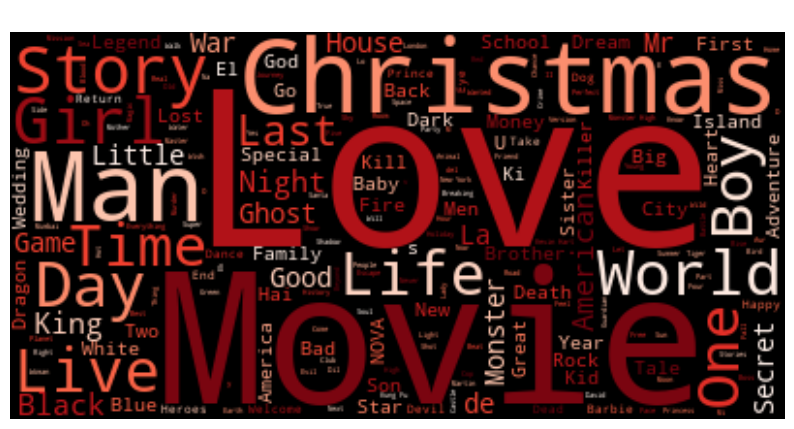

In [29]:
import matplotlib.pyplot as plt
titles = movie['title'].values

text = ' '.join(titles)

wordcloud = WordCloud(background_color='black', colormap='Reds').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Titles', color='white')
plt.show()

In [30]:
# feature extracting 
new_data = movie[['title', 'type', 'director', 'cast', 'rating', 'listed_in', 'description']]
new_data.set_index('title', inplace=True)

In [31]:
class TextCleaner:
    def separate_text(self, texts):
        unique_texts = set()
        for text in texts.split(','):
            unique_texts.add(text.strip().lower())
        return ' '.join(unique_texts)

    def remove_space(self, texts):
        return texts.replace(' ', '').lower()

    def remove_punc(self, texts):
        texts = texts.lower()
        texts = texts.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(texts.split())

    def clean_text(self, texts):
        texts = self.separate_text(texts)
        texts = self.remove_space(texts)
        texts = self.remove_punc(texts)
        return texts

In [32]:
cleaner = TextCleaner()

In [34]:
new_data['type']        = new_data['type'].apply(cleaner.remove_space)
new_data['director']    = new_data['director'].apply(cleaner.separate_text)
new_data['cast']        = new_data['cast'].apply(cleaner.separate_text)
new_data['rating']      = new_data['rating'].apply(cleaner.remove_space)
new_data['listed_in']   = new_data['listed_in'].apply(cleaner.separate_text)

In [37]:
new_data.head()

,type,director,cast,rating,listed_in,description
title,,,,,,
Sankofa,movie,haile gerima,oyafunmike ogunlano nick medley alexandra duah...,tv-ma,independent movies dramas international movies,"On a photo shoot in Ghana, an American model s..."
The Great British Baking Show,tvshow,andy devonshire,paul hollywood mel giedroyc sue perkins mary b...,tv-14,british tv shows reality tv,A talented batch of amateur bakers face off in...
The Starling,movie,theodore melfi,loretta devine kevin kline kimberly quinn rosa...,pg-13,dramas comedies,A woman adjusting to life after a loss contend...
Je Suis Karl,movie,christian schwochow,marlon boess victor boccard fleur geffrier azi...,tv-ma,dramas international movies,After most of her family is murdered in a terr...
Jeans,movie,s. shankar,nassar aishwarya rai bachchan sri lakshmi pras...,tv-14,international movies comedies romantic movies,When the father of the man she loves insists t...


In [38]:
new_data['BoW'] = new_data.apply(lambda row: ' '.join(row.dropna().values), axis=1)
new_data.drop(new_data.columns[:-1], axis=1, inplace=True)

In [39]:
new_data.head()

,BoW
title,
Sankofa,movie haile gerima oyafunmike ogunlano nick me...
The Great British Baking Show,tvshow andy devonshire paul hollywood mel gied...
The Starling,movie theodore melfi loretta devine kevin klin...
Je Suis Karl,movie christian schwochow marlon boess victor ...
Jeans,movie s. shankar nassar aishwarya rai bachchan...


In [40]:
tfid = TfidfVectorizer()
tfid_matrix = tfid.fit_transform(new_data['BoW'])

In [41]:
cosine_sim = cosine_similarity(tfid_matrix, tfid_matrix)
cosine_sim

array([[1.        , 0.01840225, 0.00982831, ..., 0.01543475, 0.00896838,
        0.02374123],
       [0.01840225, 1.        , 0.        , ..., 0.00954621, 0.00734569,
        0.01469161],
       [0.00982831, 0.        , 1.        , ..., 0.04865302, 0.02392574,
        0.01727001],
       ...,
       [0.01543475, 0.00954621, 0.04865302, ..., 1.        , 0.05332597,
        0.00560289],
       [0.00896838, 0.00734569, 0.02392574, ..., 0.05332597, 1.        ,
        0.00976782],
       [0.02374123, 0.01469161, 0.01727001, ..., 0.00560289, 0.00976782,
        1.        ]])

In [42]:
np.save('tfidf_matrix.npy', tfid_matrix)
np.save('cosine_sim_matrix.npy', cosine_sim)

In [43]:
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfid, f)

In [44]:
final_data = movie[['title', 'type']]

In [45]:
final_data.head()

,title,type
7,Sankofa,Movie
8,The Great British Baking Show,TV Show
9,The Starling,Movie
12,Je Suis Karl,Movie
24,Jeans,Movie


In [46]:
final_data.to_csv('movie_data.csv',index=False)

In [47]:
import re
class FlixHub:
    def __init__(self, df, cosine_sim):
        self.df = df
        self.cosine_sim = cosine_sim
    
    def recommendation(self, title, total_result=5, threshold=0.5):
        idx = self.find_id(title)
        self.df['similarity'] = self.cosine_sim[idx]
        sort_df = self.df.sort_values(by='similarity', ascending=False)[1:total_result+1]
        
        movies = sort_df['title'][sort_df['type'] == 'Movie']
        tv_shows = sort_df['title'][sort_df['type'] == 'TV Show']
        
        similar_movies = []
        similar_tv_shows = []
        
        for i, movie in enumerate(movies):
            similar_movies.append('{}. {}'.format(i+1, movie))
        
        for i, tv_show in enumerate(tv_shows):
            similar_tv_shows.append('{}. {}'.format(i+1, tv_show))
        
        return similar_movies, similar_tv_shows

    def find_id(self, name):
        for index, string in enumerate(self.df['title']):
            if re.search(name, string):
                return index
        return -1

The provided Python code is part of a class named `FlixHub` that seems to be a recommendation system for movies and TV shows. The class has a method named `find_id` which is used to find the index of a given title in the dataframe.

The `find_id` method takes one argument, `name`, which is the name of the movie or TV show to find. The method iterates over the 'title' column of the dataframe, which presumably contains the titles of all movies and TV shows in the database. For each title in the dataframe, it uses the `re.search` function from the `re` module to check if the given name is found in the title. The `re.search` function returns a match object if the name is found, and `None` otherwise. If the name is found, the method returns the index of the title. If the name is not found in any title, the method returns -1.

This method is likely used in the recommendation system to find the index of a movie or TV show that a user is interested in, so that the system can then find and recommend similar movies or TV shows.

In [48]:
flix_hub = FlixHub(final_data, cosine_sim)
movies, tv_shows = flix_hub.recommendation('Blood & Water', total_result=10, threshold=0.5)

print('Similar Movie(s) list:')
for movie in movies:
    print(movie)

print('\nSimilar TV_show(s) list:')
for tv_show in tv_shows:
    print(tv_show)

Similar Movie(s) list:
1. Kajraare
2. Game
3. Jatts in Golmaal
4. Blood Money
5. Baazaar
6. BluffMaster!
7. Krish Trish and Baltiboy: Face Your Fears
8. A Very Country Christmas
9. Once In A Lifetime Sessions with Moby
10. Indoo Ki Jawani

Similar TV_show(s) list:


In [56]:
flix_hub = FlixHub(final_data, cosine_sim)
movies, tv_shows = flix_hub.recommendation('Chappie', total_result=10, threshold=0.5)

print('Similar Movie(s) list:')
for movie in movies:
    print(movie)

Similar Movie(s) list:
1. District 9
2. Real Steel
3. The Last Days of American Crime
4. 2036 Origin Unknown
5. Singularity
6. Hardcore Henry
7. Equals
8. A Monster Calls
9. Next Gen
10. Alien Warfare


In [ ]:
# Quantum recommendation system using QRS algorithm

from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import numpy as np

# Function to encode movie preferences into quantum states
def encode_preferences(preferences):
    n = len(preferences)
    qc = QuantumCircuit(n)
    for i, pref in enumerate(preferences):
        theta = 2 * np.arcsin(np.sqrt(pref))
        qc.ry(theta, i)
    return qc

# Function to measure the quantum states and generate recommendations
def measure_recommendations(qc, num_recommendations):
    qc.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1000)
    result = job.result()
    counts = result.get_counts(qc)
    recommendations = {}
    for state, count in counts.items():
        pref = int(state, 2) / (2 ** num_recommendations)
        recommendations[pref] = count
    return recommendations

# Example preferences (binary representation)
preferences = [0.5, 0.8, 0.3, 0.6]

# Encode preferences into quantum states
qc = encode_preferences(preferences)

# Measure quantum states to get recommendations
recommendations = measure_recommendations(qc, len(preferences))

# Print recommendations
print("Recommendations:")
for pref, count in recommendations.items():
    print(f"Preference: {pref}, Count: {count}")

In [ ]:
# comparision of the two recommendation systems
classical_system = FlixHub(final_data, cosine_sim)
user_id = 123
classical_recommendations = classical_system.recommendation('Blood & Water', total_result=10, threshold=0.5)
print("Classical Recommendations:", classical_recommendations)

quantum_system = measure_recommendations(qc, num_recommendations)
user_preferences = {}  # User preferences encoded as quantum states
quantum_recommendations = quantum_system.recommendations(user_preferences)
print("Quantum Recommendations:", quantum_recommendations)